In [2]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = "{:,.2f}".format
import matplotlib.cm as cm

import json
import logging

import sys

sys.path.insert(1, '../fuzzylearn/')

from fuzzylearn import *
from fuzzylearn.fuzzifiers import LinearFuzzifier, CrispFuzzifier,ExponentialFuzzifier,QuantileLinearPiecewiseFuzzifier, QuantileConstantPiecewiseFuzzifier
from fuzzylearn.kernel import GaussianKernel, LinearKernel, HyperbolicKernel, PolynomialKernel, HomogeneousPolynomialKernel
from fuzzylearn import solve_optimization_gurobi

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, RobustScaler, PowerTransformer, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.manifold import TSNE

In [3]:
dataset = pd.read_excel("dataset/IncidentiModificato.xlsx")
dataset = dataset.set_index("VERBALE")

import datetime as dt

dataset.DATA = dataset.DATA.apply(lambda d: (d - dt.datetime(1970,1,1)).days)

dataset.head()

,DATA,SESSO,ANNI,PESO,ALTEZZA,BMI,Mezzo,Testa:Neurocranio,Testa:Splancnocranio,Testa:Telencefalo,...,Scheletro:Rachide-cervicale,Scheletro:Rachide-toracico,Scheletro:Rachide-lombare,Scheletro:Bacino-e-sacro,Scheletro:Complesso-sterno/claveo/costale,Tot Testa,Tot Torace,Tot Addome,Tot Scheletro,Totale
VERBALE,,,,,,,,,,,,,,,,,,,,,
85567,10893,0,81,84.00,1.75,27.43,0,1,0,0,...,0,3,0,3,3,2,0,3,9,14
85829,10970,1,69,69.00,1.62,26.29,1,4,4,4,...,0,0,0,0,4,20,7,1,4,32
85977,11026,1,71,67.00,1.55,27.89,1,2,0,1,...,0,0,0,0,4,6,0,0,4,10
86220,11122,1,54,60.00,1.59,23.73,1,4,0,0,...,0,0,0,0,4,5,3,2,4,14
86247,11130,1,78,69.00,1.67,24.74,1,2,0,0,...,0,0,0,0,4,2,0,2,4,8


In [5]:
import matplotlib.pyplot as plt

def gr_dataset(df): 
    for lab, col in zip((0, 1),
                        ('blue', 'red')):
        plt.scatter(df.values[labels.values==lab, 0],
                    df.values[labels.values==lab, 1],
                    label=lab,
                    c=col)

In [6]:
def gr_membership_contour(estimated_membership,rangex,rangey):
    x = rangex
    y = rangey
    X, Y = np.meshgrid(x, y)
    zs = np.array([estimated_membership((x, y))
                   for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    membership_contour = plt.contour(X, Y, Z,
                                     levels=(.1, .3, .5, .95), colors='k')
    plt.clabel(membership_contour, inline=1)

In [7]:
def gr_membership_graded(estimated_membership, color_map,rangex,rangey):
    x = rangex
    y = rangey
    X, Y = np.meshgrid(x, y)
    zs = np.array([estimated_membership((x, y))
                   for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    plt.imshow(Z, interpolation='bilinear', origin='lower',
               cmap=color_map, alpha=0.99, extent=(-10, 10, -10, 10))

In [8]:
anagrafica = dataset[list(dataset.columns)[1:6]]
labels = dataset['Mezzo']
lesioni = dataset[list(dataset.columns)[7:27]]

In [9]:
labels_zone = ['Testa','Torace','Addome','Scheletro']

In [10]:
df_compresso = anagrafica.copy()
for i,l in zip(range(0,len(lesioni.columns),5),labels_zone):
    zona = lesioni[list(lesioni.columns)[i:(i+5)]]
    component = PCA(n_components=1).fit_transform(zona.values)
    component_to_values = [v[0] for v in component]
    serie = pd.Series(component_to_values,index=zona.index)
    df_compresso[l] = serie

In [11]:
df_compresso.tail()

,SESSO,ANNI,PESO,ALTEZZA,BMI,Testa,Torace,Addome,Scheletro
VERBALE,,,,,,,,,
101618,1,82,80.20,1.62,30.56,-1.64,-0.92,-1.29,-3.13
101288E,1,70,75.60,1.57,30.67,-1.11,-1.50,-1.29,-1.02
E-97586,0,45,45.00,1.77,14.36,-2.17,-0.91,-1.29,1.65
X,0,54,89.60,1.68,31.75,-1.38,-0.60,-0.15,0.66
X1,1,86,50.00,1.55,20.81,-0.90,-0.60,1.03,1.65


In [12]:
tsne_values = TSNE(n_components=2).fit_transform\
            (StandardScaler().fit_transform(df_compresso.values))
df_tsne=pd.DataFrame(tsne_values,index=dataset.index)
df_tsne.head()

,0,1
VERBALE,,
85567,2.35,-2.97
85829,0.29,3.52
85977,7.60,4.08
86220,7.85,6.65
86247,5.95,4.48


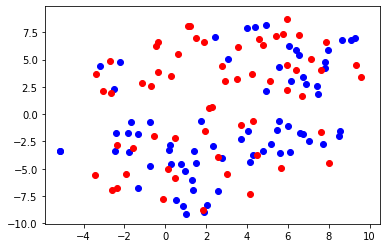

In [13]:
gr_dataset(df_tsne)

In [18]:
parameters = {
    'c' : [.1],
    'fuzzifier': [LinearFuzzifier],
    'k' : [HyperbolicKernel(1,1)]
}

In [19]:
incidenti = GridSearchCV(estimator=FuzzyInductor(),\
                         param_grid=parameters,n_jobs=-1)
incidenti.fit(df_tsne.values,labels.values)

100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


GridSearchCV(cv=None, error_score=nan,
             estimator=FuzzyInductor(c=1,
                                     fuzzifier=<class 'fuzzylearn.fuzzifiers.ExponentialFuzzifier'>,
                                     k=GaussianKernel(1), random_state=None,
                                     return_profile=False, return_vars=False,
                                     sample_generator=None,
                                     solve_strategy=(<function solve_optimization_tensorflow at 0x7fa35282d6a8>,
                                                     {})),
             iid='deprecated', n_jobs=-1,
             param_grid={'c': [0.1],
                         'fuzzifier': [<class 'fuzzylearn.fuzzifiers.LinearFuzzifier'>],
                         'k': [HyperbolicKernel(1, 1)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [20]:
incidenti.score(df_tsne.values,labels.values)

-0.2570804563062164

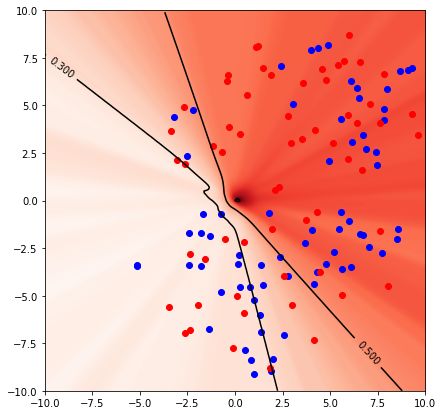

In [26]:
plt.figure(figsize=(7,7))
gr_dataset(df_tsne)
gr_membership_contour(incidenti.best_estimator_.estimated_membership_,np.arange(-10, 10, .1),np.arange(-10, 10, .1))
gr_membership_graded(incidenti.best_estimator_.estimated_membership_, cm.Reds,np.arange(-10, 10, .1),np.arange(-10, 10, .1))
plt.savefig('incidenti-vis-heavy.pdf')
plt.show()

In [21]:
mu0 = [1 if not label else 0 for label in labels.values]

In [22]:
parameters0 = {
    'c': [0.1],
    'k': [HyperbolicKernel(1,0.01)],
    'fuzzifier': [LinearFuzzifier]
}

In [23]:
incidenti0 = GridSearchCV(estimator=FuzzyInductor(),\
                         param_grid=parameters0,n_jobs=-1)
incidenti0.fit(df_tsne.values,mu0)

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


GridSearchCV(cv=None, error_score=nan,
             estimator=FuzzyInductor(c=1,
                                     fuzzifier=<class 'fuzzylearn.fuzzifiers.ExponentialFuzzifier'>,
                                     k=GaussianKernel(1), random_state=None,
                                     return_profile=False, return_vars=False,
                                     sample_generator=None,
                                     solve_strategy=(<function solve_optimization_tensorflow at 0x7fa35282d6a8>,
                                                     {})),
             iid='deprecated', n_jobs=-1,
             param_grid={'c': [0.1],
                         'fuzzifier': [<class 'fuzzylearn.fuzzifiers.LinearFuzzifier'>],
                         'k': [HyperbolicKernel(1, 0.01)]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [24]:
incidenti0.score(df_tsne.values,mu0)

-0.2336024693507136

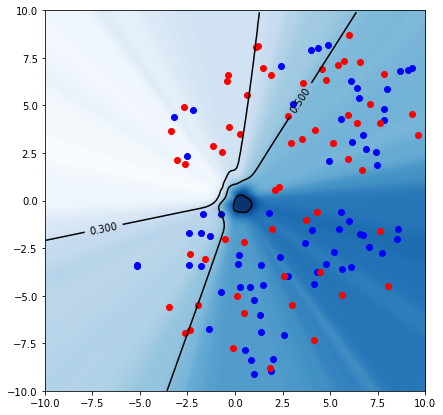

In [27]:
plt.figure(figsize=(7,7))
gr_dataset(df_tsne)
gr_membership_contour(incidenti0.best_estimator_.estimated_membership_,np.arange(-10, 10, .1),np.arange(-10, 10, .1))
gr_membership_graded(incidenti0.best_estimator_.estimated_membership_, cm.Blues,np.arange(-10, 10, .1),np.arange(-10, 10, .1))
plt.savefig('incidenti-vis-light.pdf')
plt.show()

In [26]:
plt.savefig('incidenti-vis-light.pdf')

<Figure size 432x288 with 0 Axes>